### Convolutional Neural Network - 과적합 방지 #1 (컬러 이미지).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings  
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets.cifar10 import load_data
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping
warnings.filterwarnings('ignore')                  # Turn the warnings off.
%matplotlib inline

#### 1. 데이터 불러오기:

자세한 설명은 [이곳](https://www.cs.toronto.edu/~kriz/cifar.html)을 참고한다.

In [2]:
# 데이터 가져오기.
(X_train, y_train), (X_test, y_test) = load_data()
n_train_size = X_train.shape[0]
n_test_size = X_test.shape[0]

In [3]:
# Shape 확인.
print("-"*50)
print("Training data X shape: {}".format(X_train.shape))
print("Training data y shape: {}".format(y_train.shape))
print("-"*50)
print("Test data X shape: {}".format(X_test.shape))
print("Test data y shape: {}".format(y_test.shape))
print("-"*50)

--------------------------------------------------
Training data X shape: (50000, 32, 32, 3)
Training data y shape: (50000, 1)
--------------------------------------------------
Test data X shape: (10000, 32, 32, 3)
Test data y shape: (10000, 1)
--------------------------------------------------


#### 2. 데이터 시각화:

In [4]:
name_dict = {0:"Airplane", 1:"Automobile", 2:"Bird", 3:"Cat", 4:"Deer", 5:"Dog", 6:"Frog", 7:"Horse", 8:"Ship", 9:"Truck"}

Y 레이블 : Cat


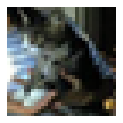

Y 레이블 : Automobile


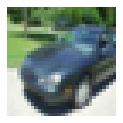

Y 레이블 : Frog


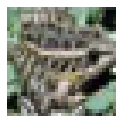

Y 레이블 : Deer


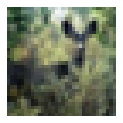

Y 레이블 : Cat


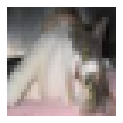

In [5]:
# 이미지 데이터 시각화 (5개).
for i_image in [ random.randint(0,n_train_size-1) for _ in range(5)]:
    print("Y 레이블 :",name_dict[y_train[i_image][0]])
    plt.figure(figsize=(2,2))
    plt.imshow(X_train[i_image])
    plt.axis("off")
    plt.show()

#### 3. 데이터 준비:

In [6]:
# Scaling.
X_train = X_train/255                   
X_test = X_test/255                        

In [7]:
# 4 차원 배열로 reshaping 해준다.
X_train = X_train.reshape(-1,32,32,3)
X_test = X_test.reshape(-1,32,32,3)

In [8]:
# One-hot-encoding.
y = np.concatenate([y_train,y_test],axis=0)
y = to_categorical(y,10)
y_train = y[:n_train_size,:]
y_test = y[n_train_size:,:]

#### 4. CNN 모델 정의 (BatchNormalization, Regularization):

In [9]:
# 과적합 방지 방법 적용!
# 1. Dropoput.
# 2. BatchNormalization (배치 정규화).
# 3. L2 정규화 (regularization).

drop_prob = 0.7
gamma = 0.0001
my_model = Sequential()
# 1st convolution + pooling.
my_model.add(Conv2D(input_shape=(32,32,3),filters=32,kernel_size=(5,5),padding='same',activation="relu", name="Conv-1"))        # 3 channels of color.
my_model.add(MaxPooling2D(pool_size=2, name="Pooling-1"))
my_model.add(BatchNormalization(name="BatchNormazliation"))                                            # 배치 정규화.
# 2nd convolution + pooling.
my_model.add(Conv2D(filters=64,kernel_size=(5,5), padding='same',activation="relu", name="Conv-2"))
my_model.add(MaxPooling2D(pool_size=2, name="Pooling-2"))
# Flattened fully connected layer.
my_model.add(Flatten(name="Flatten"))
my_model.add(Dense(units = 1024, activation="relu", name="Dense-1", kernel_regularizer=l2(gamma), bias_regularizer=l2(gamma)))  # L2 정규화 적용!
# Apply dropout.
my_model.add(Dropout(rate=drop_prob, name="Dropout"))
# Output layer.
my_model.add(Dense(units = 10, activation="softmax", name="Dense-2"))

In [10]:
# 모델의 summary (내부 구조) 출력.
# Conv-1의 파라미터 수 = n_channels * n_filters1 * n_kernel_elements1 + n_filters1 = 3 * 32 * (5*5) + 32 = 2432
# Conv-2의 파라미터 수 = n_filters1 * n_filters2 * n_kernel_elements2 + n_filters2 = 32 * 64 * (5*5) + 64 = 51264.
# Dense-1의 파라미터 수 = 이전층의 출력 * n_nodes + n_nodes = 4096 * 1024 + 1024 = 4195328.
# Dense-2의 파라미터 수 = 이전층의 출력 * n_output + n_output = 1024 * 10 + 10 = 10250.
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv-1 (Conv2D)             (None, 32, 32, 32)        2432      
                                                                 
 Pooling-1 (MaxPooling2D)    (None, 16, 16, 32)        0         
                                                                 
 BatchNormazliation (BatchNo  (None, 16, 16, 32)       128       
 rmalization)                                                    
                                                                 
 Conv-2 (Conv2D)             (None, 16, 16, 64)        51264     
                                                                 
 Pooling-2 (MaxPooling2D)    (None, 8, 8, 64)          0         
                                                                 
 Flatten (Flatten)           (None, 4096)              0         
                                                        

#### 5. Hyperparameter 와 Optimizer 정의:

In [11]:
# Hyperparameters.
n_epochs = 30
batch_size = 32
learn_rate = 0.0001

In [12]:
# Optimizer 객체 생성 후 컴파일한다.
my_optimizer=Adam(lr=learn_rate)
my_model.compile(loss = "categorical_crossentropy", optimizer = my_optimizer, metrics=["accuracy"])

#### 6. 학습 & History 시각화:

In [13]:
# 학습.
# verbose = 0 : 출력 없음. verbose = 1 : 출력 함.
my_EarlyStop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)          # 조기 종료 허락!
my_summary = my_model.fit(X_train, y_train, epochs=n_epochs, batch_size = batch_size, validation_split = 0.3, verbose = 1,callbacks=[my_EarlyStop])

Epoch 1/30
1094/1094 [==============================] - 57s 52ms/step - loss: 1.8709 - accuracy: 0.3864 - val_loss: 1.6159 - val_accuracy: 0.4846
Epoch 2/30
1094/1094 [==============================] - 57s 52ms/step - loss: 1.5368 - accuracy: 0.5027 - val_loss: 1.5487 - val_accuracy: 0.5147
Epoch 3/30
1094/1094 [==============================] - 57s 52ms/step - loss: 1.3709 - accuracy: 0.5635 - val_loss: 1.2677 - val_accuracy: 0.5961
Epoch 4/30
1094/1094 [==============================] - 58s 53ms/step - loss: 1.2407 - accuracy: 0.6064 - val_loss: 1.1477 - val_accuracy: 0.6421
Epoch 5/30
1094/1094 [==============================] - 57s 52ms/step - loss: 1.1327 - accuracy: 0.6409 - val_loss: 1.1351 - val_accuracy: 0.6417
Epoch 6/30
1094/1094 [==============================] - 58s 53ms/step - loss: 1.0504 - accuracy: 0.6708 - val_loss: 1.2261 - val_accuracy: 0.6189
Epoch 7/30
1094/1094 [==============================] - 58s 53ms/step - loss: 0.9781 - accuracy: 0.6919 - val_loss: 1.0115 -

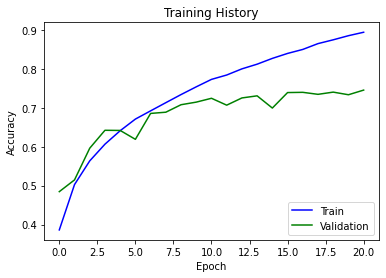

In [14]:
# 학습 history 출력. 
n_skip = 0                 # Skip the first few steps.
plt.plot(my_summary.history['accuracy'][n_skip:], c="b")
plt.plot(my_summary.history['val_accuracy'][n_skip:], c="g")
plt.title('Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

#### 7.  테스팅: 

정답 : Bird
1/1 [==============================] - 0s 80ms/step
예측 : Frog


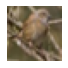

정답 : Bird
1/1 [==============================] - 0s 13ms/step
예측 : Bird


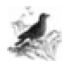

정답 : Deer
1/1 [==============================] - 0s 14ms/step
예측 : Horse


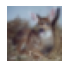

정답 : Deer
1/1 [==============================] - 0s 15ms/step
예측 : Cat


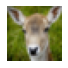

정답 : Truck
1/1 [==============================] - 0s 13ms/step
예측 : Truck


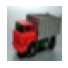

In [15]:
# 랜덤으로 테스트 이미지를 추출해서 예측해 본다.
for i_image in [ random.randint(0,n_test_size-1) for _ in range(5)]:
    print("정답 :" , name_dict[np.argmax(y_test[i_image])])
    print("예측 :" , name_dict[np.argmax(my_model.predict(X_test[i_image].reshape(1,32,32,3)))])     # 4 차원 배열로 reshaping 해준다!!!
    plt.figure(figsize=(1,1))
    plt.imshow(X_test[i_image])
    plt.axis("off")
    plt.show()

In [16]:
# 최종적으로 정확도 계산.
ACC = my_model.evaluate(X_test, y_test, verbose=0)[1]    
print("Test Accuracy : {}".format(np.round(ACC,3)))

Test Accuracy : 0.748
